# UPRM Hackathon 2024 - Text Classification with Neural Networks

* <b> Author: </b> Yeshi Soleti, Hamzah Abdulrazzaq, Stephen Palmier
* <b> Date: </b> September 6th, 2024
* <b> Objective: 
   </b> This hackathon is centered on Natural Language Processing, with a particular emphasis on classification using Neural Networks. We will be utilizing the "Web of Science" dataset consisting of 46,985 documents with 134 categories which include 6 parents categories. The primary objective is to construct a Multi-Layer Perceptron that can accurately predict the parent categories based on the text input. Tackling this task, given that the dataset consists of 6 parent categories, will undoubtedly prove to be a challenging endeavor. Achieving optimal results will necessitate a comprehensive approach, including data cleaning, preprocessing, hyperparameter tuning, application of regularization techniques, and modifications to the network architecture. Criteria for winning submissions is determined by F1 score. The starter notebook provided here offers initial steps, helper functions, and documentation to help you succeed. While the notebook lays the groundwork, the onus is on participants to explore, innovate, and refine their models to meet the desired outcomes. 


## Table of Contents

- [Background Information: Multi-Layer Perceptrons](#Background-Information:-MultiLayer-Perceptrons)
- [Importing Necessary Libraries](#Importing-Necessary-Libraries)
- [Config Class + Basic Visualization](#Config-Class-+-Basic-Visualization)
- [Data Imbalance](#Data-Imbalance)
- [Preprocess and Set Up Custom Datset](#Preprocess-and-Set-Up-Custom-Dataset)
- [Model Architecture](#Model-Architecture)
- [Train Model](#Train-Model)
- [Visualize Loss and Accuracy](#Visualize-Loss-and-Accuracy)
- [Test Model on Test Set](#Test-Model-on-Test-Set)
- [Confusion Matrix](#Confusion-Matrix)
- [Where is the Model Underperforming](#Where-is-the-model-underperforming?)
- [Submit Score](#Submissions)

## Background Information: MultiLayer Perceptrons

A multi-layer perceptron (MLP) is a type of deep neural network that excels at classification problems. Known for their versatility, MLPs are used in a wide range of tasks, including image recognition, image classification, speech recognition, text classification, time series forecasting, and recommendation systems.

MLPs are fully connected deep neural networks. That means they consist of at least three layers: an input layer, one or more hidden layers, and an output layer. Each neuron in a layer is connected to every neuron in the next layer, making them fully connected. This architecture enables MLPs to learn and model complex relationships between input features and output labels. This is especially useful for text classification tasks like this. While they can model complex relationships, they are prone to overfitting. Regularization techniques, such as L1 and L2 regularization, dropout, or early stopping, can help mitigate overfitting and improve the model's performance.

Multi-layer perceptrons stem from perceptrons. A perceptron is a single-layer artificial neural network that consists of a single neuron. It directly extended the model of how neurons work in our brains. However, the limitations of perceptrons in handling non-linear problems led to the development of multi-layer perceptrons. The hidden layers in an MLP contain neurons that apply non-linear activation functions to the weighted sum of their inputs, enabling the model to learn non-linear decision boundaries and make more accurate predictions.

Check out this [article](https://towardsdatascience.com/multilayer-perceptron-explained-with-a-real-life-example-and-python-code-sentiment-analysis-cb408ee93141) to learn more about the history and math behind MLPs. This [interactive demo](https://chokkan.github.io/deeplearning/demo-mlp.html) helps visualize how changing the MLP weights, biases, and activation functions affect the output.

<img src="https://miro.medium.com/v2/resize:fit:563/1*4_BDTvgB6WoYVXyxO8lDGA.png" style="width: 400px;">
<br>

A typical MLP architecture for text classification consists of:

**Input Layer** - this layer contains the input text data, typically represented as a vector of word embeddings. The number of neurons in this layer corresponds to the dimensionality of the word embeddings.

**Hidden Layer(s)** - these layers are responsible for learning and modeling the complex relationships between the input text data and the output labels. Each hidden layer contains one or more densely connected layers, also known as fully connected layers, where each neuron in a layer is connected to every neuron in the next layer. These layers apply non-linear activation functions, such as ReLU or Sigmoid, to the weighted sum of their inputs, allowing the model to learn non-linear decision boundaries and make more accurate predictions.

**Dropout Layer(s)** - these layers are used to prevent overfitting by randomly setting a fraction of the neurons to zero during training. This ensures no single neuron becomes 'overspecialized'. 

**Output Layer** - this layer takes the final calculation and converts it to a probability score for each class.   


## Importing Necessary Libraries 

In [1]:
!pip install -r requirements.txt

In [26]:
import pandas as pd
import numpy as np
import torch   
import matplotlib.pyplot as plt
import re
import torch.nn as nn
import seaborn as sns
import nltk

from collections import Counter, defaultdict
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from nltk.stem import PorterStemmer
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from wordcloud import WordCloud

from typing import List,Dict
from sklearn.utils import resample

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train_data = pd.read_csv('./data/train_data.csv')  # read in training data
valid_data = pd.read_csv('./data/valid_data.csv')  # read in validation data
test_data = pd.read_csv('./data/test_data.csv')  # read in test data
# reported score will be based on model performance on test data 

In [6]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

In [7]:
train_data['Domain'].value_counts()

Domain
Medical         8524
Psychology      2923
CS              2700
ECE             2302
Civil           1787
MAE             1364
Name: count, dtype: int64

### Config Class + Basic Visualization

**Note:** The config class is often used to centralize various settings and parameters. For our purposes, we will be using it to make sure all of our configuration settings are in one place

In [8]:
class Config:
    batch_size = 16
    learning_rate = 0.001
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    epochs = 10 # increase as needed

In [9]:
def to_numpy(x):
    return x.cpu().numpy()

#### Basic Dataset Information and Summary Statistics

In [10]:
print(f'Shape of Train Dataset: {train_data.shape}')
print(f'Shape of Validation Dataset: {valid_data.shape}')
print(f'Shape of Testing Dataset: {test_data.shape}')
print('--'*20)
print(f'Column Names: {train_data.columns.tolist()}')
print('--'*20)
print(f'Missing Values: \n{train_data.isnull().sum()}')

Shape of Train Dataset: (19600, 3)
Shape of Validation Dataset: (12000, 3)
Shape of Testing Dataset: (8400, 3)
----------------------------------------
Column Names: ['Y1', 'Domain', 'Abstract']
----------------------------------------
Missing Values: 
Y1          0
Domain      0
Abstract    0
dtype: int64


#### Text Length Distribution

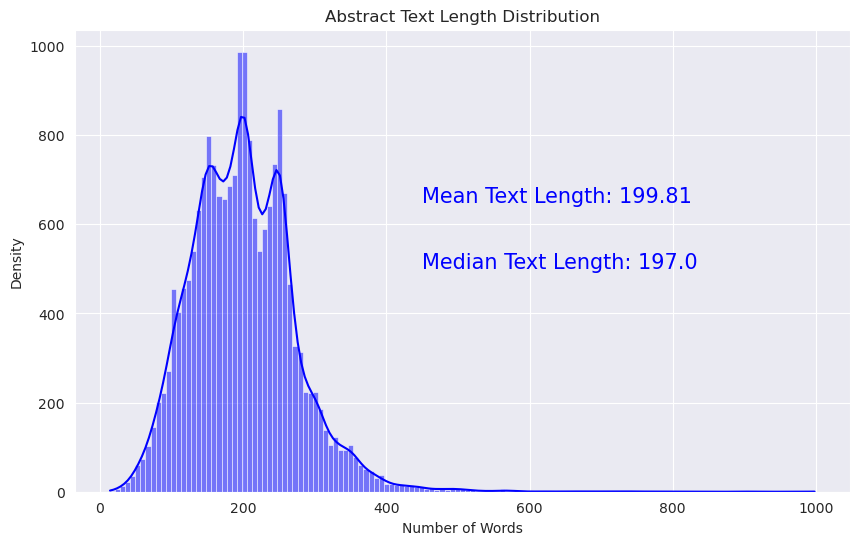

In [11]:
text_lengths = train_data['Abstract'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10,6))
sns.set_style('darkgrid')
sns.histplot(text_lengths, kde=True, color='blue')
plt.title('Abstract Text Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Density')
plt.text(450, 650, f'Mean Text Length: {np.round(np.mean(text_lengths),2)}', fontsize = 15, color='blue')
plt.text(450, 500, f'Median Text Length: {np.median(text_lengths)}', fontsize = 15, color='blue')
plt.show()

#### WordCloud per Class

In [12]:
# function to preprocess our text
def preprocess_text(col, stop_words, stemmer):
    """
    Arguments:
    1. col to preprocess
    2. list of stop_words
    3. word stemmer

    steps: tokenize -> lower case ->
            remove stop words -> stem
    """
    col = re.sub(r"[^a-zA-Z0-9 ]", "", col) # keep only letters and numbers 
    tokenize = col.split() # word tokenize 
    lower_case = [word.lower() for word in tokenize] # lower case everything 
    remove_stop_words = [word for word in lower_case if word not in stop_words] 
    stemmed_words = [stemmer.stem(word) for word in remove_stop_words]
    result = " ".join(stemmed_words)
    return result

In [13]:
print(train_data.head())

   Y1    Domain                                           Abstract
0   5  Medical   Facility-based antiretroviral therapy (ART) pr...
1   3      MAE   This paper proposes an axial-flux-modulation p...
2   5  Medical   Background: Early diagnosis of esophageal squa...
3   5  Medical   Few studies have examined the effect of black ...
4   1      ECE   The exact expression for the effective resista...


In [14]:
#Stopword Adder 3000

# Define the domains based on the 'Domain' column of the train_data DataFrame
domains = set(train_data['Domain'])

# Load stopwords and stemmer for text preprocessing
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Dictionary to track the number of domains each word appears in
word_domain_count = defaultdict(int)

# Loop through each domain
for domain in domains:
    # Filter the rows associated with the current domain
    associated_rows = train_data[train_data['Domain'] == domain].reset_index(drop=True)
    
    # Preprocess the 'Abstract' column of the filtered DataFrame
    associated_rows['Abstract'] = associated_rows['Abstract'].apply(lambda x: preprocess_text(x, stop_words, stemmer))
    
    # Combine all the preprocessed abstracts into a single string
    all_text = ' '.join(associated_rows['Abstract'])
    
    # Generate word set for the current domain
    words = set(all_text.split())
    
    # Update the domain count for each word
    for word in words:
        word_domain_count[word] += 1

# Identify words to add
words_to_add = set()

for word, count in word_domain_count.items():
    if count > 4:
        words_to_add.add(word)

#print(f"Added to stopwords: {', '.join(words_to_add)}")
#print(f"Total stopwords count: {len(stop_words)}")

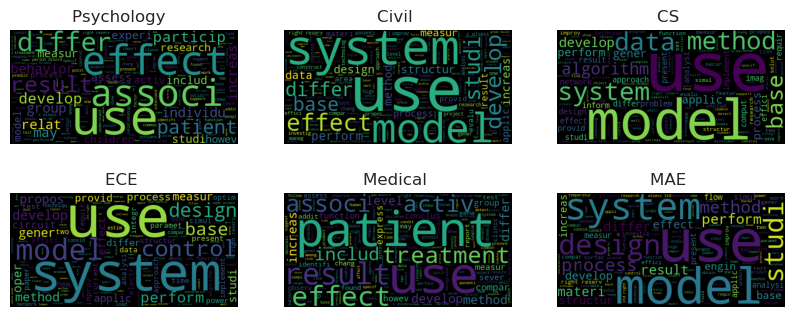

In [15]:
# Define the domains based on the 'Domain' column of the train_data DataFrame
domains = set(train_data['Domain'])

# Load stopwords and stemmer for text preprocessing
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()

# Define the keyword arguments for the preprocessing function
kwargs = {'stop_words': stop_words,
           'stemmer': stemmer}

# Create the figure with the specified size (width, height)
fig = plt.figure(figsize=(10,6))

# Loop through each domain
for j, domain in enumerate(domains):
    
    # Filter the rows associated with the current domain
    associated_rows = train_data[train_data['Domain'] == domain].reset_index(drop=True)
    
    # Preprocess the 'Abstract' column of the filtered DataFrame
    associated_rows['Abstract'] = associated_rows['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))
    
    # Combine all the preprocessed abstracts into a single string
    all_text = ' '.join(associated_rows['Abstract'])
    
    # Generate the word cloud using the combined text
    word_cloud = WordCloud().generate(all_text)
    
    # Add the word cloud to the figure at the specified position
    ax = fig.add_subplot(3, 3, j+1)
    ax.imshow(word_cloud)
    
    # Remove the axis for better visualization
    ax.axis('off')
    
    # Set the title for each subplot
    ax.set_title(domain)

# Display the figure
plt.show()

## Data Imbalance

#### $\hspace{3mm}$ i. Defintion

$\hspace{6mm}$ An imbalanced dataset is simply a dataset where the class proportions are skewed. Below is a plot showing the data imbalance in our dataset.

<BarContainer object of 6 artists>

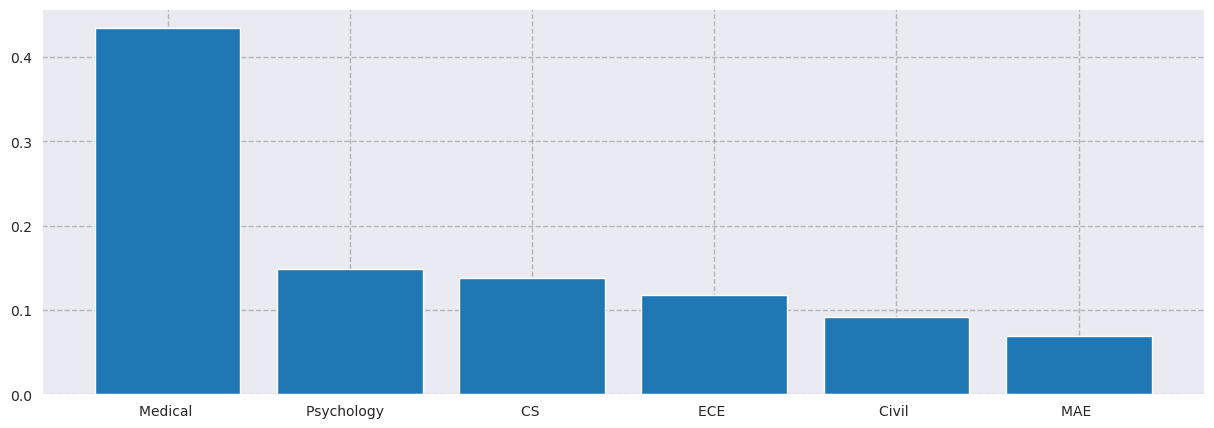

In [16]:
figure = plt.figure(figsize=(15,5))
class_counts = train_data['Domain'].value_counts(normalize=True)
plt.grid(color='gray', linestyle='--', linewidth=1, alpha=0.5)  # set grid properties
plt.bar(x=class_counts.index, height=class_counts.values)

#### $\hspace{3mm}$ ii. Strategies for handling it 

$\hspace{6mm}$There are quite a few approaches to choose from to combat imbalanced datasets: 
> 1. Resampling Methods (Oversampling/Undersampling)
2. Cost-sensitive Learning (including weights for each class in a loss function)
3. Data Augmentation

$\hspace{12mm}$and many more!

 

$\hspace{6mm}$ You can refer to the pretraining materials for details on how to implement these strategies!

In [27]:
len(words) > target_countwords.pop()
    balance_data = TARGET_COUNT = 3000 # target 3000 samples per class
# NOTE: YOU SHOULD ONLY BALANCE TRAINING DATASET
def balance_data(df, target_count):
    """ Arguments: 1. df to balance
                   2. desired count in each class
        Steps: 1. Separate the different classes in the dataframe
               2. loop through each class 
                   a. if its a majority class -> undersample
                   b. if its a minority class -> oversample
               3. concat into one dataframe
               
    """
            
    ## TODO

     # Identify the target column
    target_col = 'Domain'  # replace with your actual target column name
    
    # Separate the dataframe by class
    classes = df[target_col].unique()
    balanced_data_list = []
    
    for cls in classes:
        class_data = df[df[target_col] == cls]
        
        if len(class_data) > target_count:
            # Undersample majority class
            class_data_balanced = resample(class_data, 
                                           replace=False,    # without replacement
                                           n_samples=target_count,  # to target_count
                                           random_state=42)  # for reproducibility
        elif len(class_data) < target_count:
            # Oversample minority class
            class_data_balanced = resample(class_data, 
                                           replace=True,     # with replacement
                                           n_samples=target_count,  # to target_count
                                           random_state=42)  # for reproducibility
        else:
            # Already balanced
            class_data_balanced = class_data
        
        balanced_data_list.append(class_data_balanced)
    
    # Combine all balanced class dataframes into one
    balanced_data = pd.concat(balanced_data_list, axis=0)
    
    return balanced_data

## Preprocess and Set Up Custom Dataset

In [28]:
# apply preprocessing to each df
stop_words = set(stopwords.words("english"))
stemmer = PorterStemmer()
kwargs = {'stop_words': stop_words,
           'stemmer': stemmer}
train_data['Abstract'] = train_data['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))
valid_data['Abstract'] = valid_data['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))
test_data['Abstract_preprocessed'] = test_data['Abstract'].apply(lambda x: preprocess_text(x, **kwargs))

print("stopwords:", len(stop_words))

stopwords: 179


In [29]:
# set up countvectorizer and tfidf 

X_train = train_data['Abstract']
y_train = np.array(train_data['Y1'])

X_val = valid_data['Abstract']
y_val = np.array(valid_data['Y1'])

X_test = test_data['Abstract_preprocessed']
y_test = np.array(test_data['Y1'])

count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

X_val_counts = count_vec.transform(X_val)
X_val_tfidf = tfidf_transformer.transform(X_val_counts)

X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [30]:
class CustomDataset(Dataset):
    def __init__(self, X, y, index):
        self.X = X
        self.y = y
        self.index = index
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.index[idx]
    
    
X_train = torch.from_numpy(np.array(X_train_tfidf.todense())).float()
y_train = torch.from_numpy(y_train)
idx_train = torch.from_numpy(np.array(train_data.index))

X_val = torch.from_numpy(np.array(X_val_tfidf.todense())).float()
y_val = torch.from_numpy(y_val)
idx_val = torch.from_numpy(np.array(valid_data.index))

X_test = torch.from_numpy(np.array(X_test_tfidf.todense())).float()
y_test = torch.from_numpy(y_test)
idx_test = torch.from_numpy(np.array(valid_data.index))


train_ds = CustomDataset(X_train, y_train, idx_train)
valid_ds = CustomDataset(X_val, y_val, idx_val)
test_ds = CustomDataset(X_test, y_test, idx_test)

## Model Architecture

### Note: Below is a basic MLP architecture to help you get started. You will need add additional layers and customizations to get the desired model performance.

In [31]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 2048)
        self.layer2 = nn.Linear(2048, 1024)
        self.layer3 = nn.Linear(1024, 512)
        self.layer4 = nn.Linear(512, 256)
        self.layer5 = nn.Linear(256, num_classes)
        self.drop = nn.Dropout(0.7)
    
    def forward(self, x):
        x = self.layer1(x)
        x = nn.ReLU()(x)

        x = self.drop(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        
        x = self.drop(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        
        x = self.drop(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        
        x = self.layer5(x)
        x = nn.Softmax(dim=1)(x)

        return x

## Train Model

In [32]:
def train_model(NeuralNet, train_ds, valid_ds, epochs, learning_rate, batch_size, model_kwargs):
    torch.manual_seed(10)
    model = NeuralNet(**model_kwargs).to(Config.device)
    print(model)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

    loss_hist_train = []
    loss_hist_val = []
    acc_hist_train = []
    acc_hist_val = []
    f1_hist_train = []
    f1_hist_val = []


    for epoch in range(epochs):
        running_hist_loss = 0.0
        running_hist_acc = 0.0
        running_hist_f1 = 0.0
        lens = 0.0
        model.train()
        num_batches = 0.0
        for x_batch, y_batch, _ in tqdm(train_dl):
            x_batch, y_batch = x_batch.to(Config.device), y_batch.to(Config.device)
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            running_hist_loss += loss.item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            f1_score_calc = f1_score(to_numpy(torch.argmax(pred, dim=1)), to_numpy(y_batch), average='macro')
            running_hist_f1 += f1_score_calc
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            running_hist_acc += is_correct.sum()
            lens += len(x_batch)
            num_batches += 1
        running_hist_acc /= lens
        running_hist_loss /= lens
        running_hist_f1 /= np.ceil(len(train_dl.dataset.X)/batch_size)


        running_hist_loss_test = 0.0
        running_hist_acc_test = 0.0
        running_hist_f1_test = 0.0
        lens = 0.0
        model.eval()
        with torch.no_grad():
            for x, y, _ in tqdm(valid_dl):
                x, y = x.to(Config.device), y.to(Config.device)
                pred = model(x)
                loss = criterion(pred, y)
                running_hist_loss_test += loss.item()
                f1_score_calc = f1_score(to_numpy(torch.argmax(pred, dim=1)), to_numpy(y), average='macro')
                running_hist_f1_test += f1_score_calc
                is_correct = (torch.argmax(pred, dim=1) == y)
                running_hist_acc_test += is_correct.float().sum()
                lens += len(x)

            running_hist_loss_test /= lens
            running_hist_acc_test /= lens
            running_hist_f1_test /= np.ceil(len(valid_dl.dataset.X)/batch_size)
        print(f'Predicted Test: {torch.argmax(pred, dim=1).detach().cpu().numpy()}')
        print(f'Actual Test:    {y.detach().cpu().numpy()}')
        print(f"Epoch {epoch}")
        print("Train Loss: \t{:.4f}".format(running_hist_loss))
        print("Validation Loss: \t{:.4f}".format(running_hist_loss_test))
        print("Train Accuracy: \t{:.3f}".format(running_hist_acc))
        print("Validation Accuracy: \t{:.3f}".format(running_hist_acc_test))
        print("Train F1: \t{:.3f}".format(running_hist_f1))
        print("Validation F1: \t{:.3f}".format(running_hist_f1_test))
        print("------------------------------")

            # save best model based on accuracy
        if (epoch > 1 and running_hist_loss_test < np.min(acc_hist_val)) or epoch == 1:
            torch.save(model.state_dict(), "./models/checkpoint.pt")

        loss_hist_train.append(running_hist_loss)
        loss_hist_val.append(running_hist_loss_test)
        acc_hist_val.append(running_hist_acc_test.detach().cpu().numpy())
        acc_hist_train.append(running_hist_acc.detach().cpu().numpy())
        f1_hist_train.append(running_hist_f1)
        f1_hist_val.append(running_hist_f1_test)

        

        
    # instantiate model and load best weights
    model = NeuralNet(**model_kwargs)
    model.load_state_dict(torch.load("./models/checkpoint.pt"))
    model.eval()

    return model, loss_hist_train, loss_hist_val, acc_hist_train, acc_hist_val, f1_hist_train, f1_hist_val

In [33]:
kwargs = {'input_size': train_ds.X.shape[1],
          'num_classes': 6}
model, loss_train, loss_val, acc_train, acc_val, f1_train, f1_val = train_model(NeuralNet, train_ds, valid_ds, Config.epochs, Config.learning_rate, 
                                                                            Config.batch_size, kwargs)

NeuralNet(
  (layer1): Linear(in_features=95407, out_features=2048, bias=True)
  (layer2): Linear(in_features=2048, out_features=1024, bias=True)
  (layer3): Linear(in_features=1024, out_features=512, bias=True)
  (layer4): Linear(in_features=512, out_features=256, bias=True)
  (layer5): Linear(in_features=256, out_features=6, bias=True)
  (drop): Dropout(p=0.7, inplace=False)
)


100%|██████████| 750/750 [00:06<00:00, 119.24it/s]


Predicted Test: [1 5 5 5 1 1 5 5 5 5 0 5 5 5 5 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 0
Train Loss: 	0.0954
Validation Loss: 	0.0839
Train Accuracy: 	0.512
Validation Accuracy: 	0.701
Train F1: 	0.232
Validation F1: 	0.494
------------------------------


100%|██████████| 750/750 [00:06<00:00, 117.02it/s]


Predicted Test: [4 5 5 2 1 1 5 4 4 5 0 5 5 5 5 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 1
Train Loss: 	0.0813
Validation Loss: 	0.0795
Train Accuracy: 	0.740
Validation Accuracy: 	0.770
Train F1: 	0.561
Validation F1: 	0.614
------------------------------


100%|██████████| 750/750 [00:06<00:00, 117.59it/s]


Predicted Test: [4 5 4 2 1 1 5 4 4 5 0 5 5 5 5 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 2
Train Loss: 	0.0787
Validation Loss: 	0.0779
Train Accuracy: 	0.783
Validation Accuracy: 	0.796
Train F1: 	0.624
Validation F1: 	0.645
------------------------------


100%|██████████| 750/750 [00:06<00:00, 118.33it/s]


Predicted Test: [4 5 4 2 1 1 5 4 4 5 0 5 5 5 2 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 3
Train Loss: 	0.0779
Validation Loss: 	0.0774
Train Accuracy: 	0.796
Validation Accuracy: 	0.805
Train F1: 	0.646
Validation F1: 	0.660
------------------------------


100%|██████████| 750/750 [00:06<00:00, 117.98it/s]


Predicted Test: [4 5 4 2 1 1 5 1 1 5 0 5 5 5 5 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 4
Train Loss: 	0.0774
Validation Loss: 	0.0783
Train Accuracy: 	0.805
Validation Accuracy: 	0.790
Train F1: 	0.655
Validation F1: 	0.638
------------------------------


100%|██████████| 750/750 [00:06<00:00, 118.70it/s]


Predicted Test: [4 5 4 2 1 1 5 4 4 5 0 5 5 5 2 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 5
Train Loss: 	0.0775
Validation Loss: 	0.0772
Train Accuracy: 	0.803
Validation Accuracy: 	0.808
Train F1: 	0.658
Validation F1: 	0.666
------------------------------


100%|██████████| 750/750 [00:06<00:00, 118.61it/s]


Predicted Test: [4 5 4 2 1 1 5 3 3 5 0 5 5 5 2 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 6
Train Loss: 	0.0769
Validation Loss: 	0.0776
Train Accuracy: 	0.812
Validation Accuracy: 	0.802
Train F1: 	0.671
Validation F1: 	0.667
------------------------------


100%|██████████| 750/750 [00:06<00:00, 119.28it/s]


Predicted Test: [4 5 4 2 1 1 5 1 5 5 0 5 5 5 5 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 7
Train Loss: 	0.0772
Validation Loss: 	0.0782
Train Accuracy: 	0.808
Validation Accuracy: 	0.792
Train F1: 	0.666
Validation F1: 	0.653
------------------------------


100%|██████████| 750/750 [00:06<00:00, 119.14it/s]


Predicted Test: [4 5 4 2 1 1 5 4 5 5 3 5 5 5 5 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 8
Train Loss: 	0.0776
Validation Loss: 	0.0786
Train Accuracy: 	0.802
Validation Accuracy: 	0.786
Train F1: 	0.667
Validation F1: 	0.651
------------------------------


100%|██████████| 750/750 [00:06<00:00, 117.30it/s]


Predicted Test: [4 5 4 2 1 1 5 4 4 5 0 5 5 5 2 1]
Actual Test:    [4 5 4 2 1 1 5 3 2 0 0 5 5 2 2 1]
Epoch 9
Train Loss: 	0.0774
Validation Loss: 	0.0766
Train Accuracy: 	0.806
Validation Accuracy: 	0.818
Train F1: 	0.664
Validation F1: 	0.690
------------------------------


### Visualize Loss and Accuracy

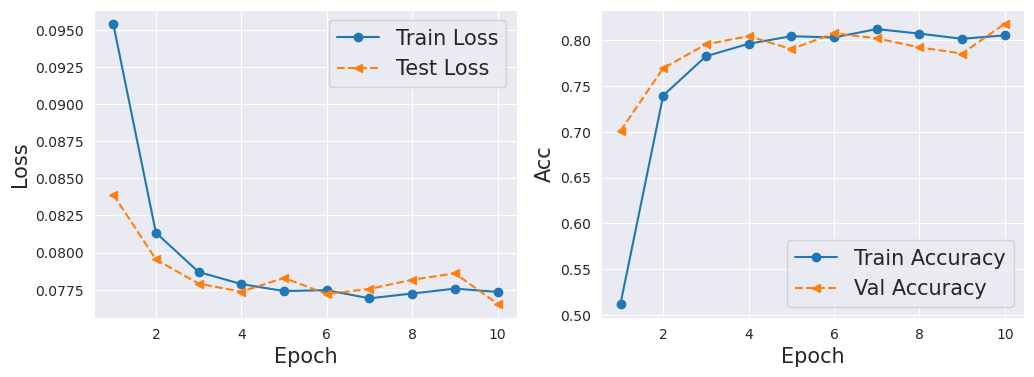

In [34]:
# define x_axis range and set up fig
x_axis = np.arange(Config.epochs) + 1
fig = plt.figure(figsize=(12,4))

# set up first subplot for train loss vs test loss
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_axis, loss_train, '-o', label='Train Loss')
ax.plot(x_axis, loss_val, '--<', label='Test Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)


# set up second subplot for train accuracy vs test accuracy
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_axis, acc_train, '-o', label='Train Accuracy')
ax.plot(x_axis, acc_val, '--<', label='Val Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Acc', size=15)
plt.show()

### Test Model On Test Set

In [35]:
test_dl = DataLoader(test_ds, batch_size=Config.batch_size, shuffle=False)

accuracy_test = 0.0
actual_labels = []
predicted_labels = []
incorrect_predictions = []
with torch.no_grad():
    # disables gradient 
    val_loss = 0.0
    for x, y, index in tqdm(test_dl):
        pred = model(x) #predict 
        is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
        accuracy_test += is_correct.mean()
        idxs = torch.where(torch.argmax(pred, 1) != y)[0].cpu().numpy()
        incorrect_predictions.append((index[idxs], torch.argmax(pred,1)[idxs]))
        actual_labels.append(to_numpy(y))
        predicted_labels.append(to_numpy(torch.argmax(pred, dim=1)))
    accuracy_test /= len(test_dl.dataset) 

predicted_labels = [item for sublist in predicted_labels for item in sublist]
actual_labels = [item for sublist in actual_labels for item in sublist]
F1_score = f1_score(actual_labels, predicted_labels, average='macro')

100%|██████████| 525/525 [00:10<00:00, 51.14it/s]


# Confusion Matrix

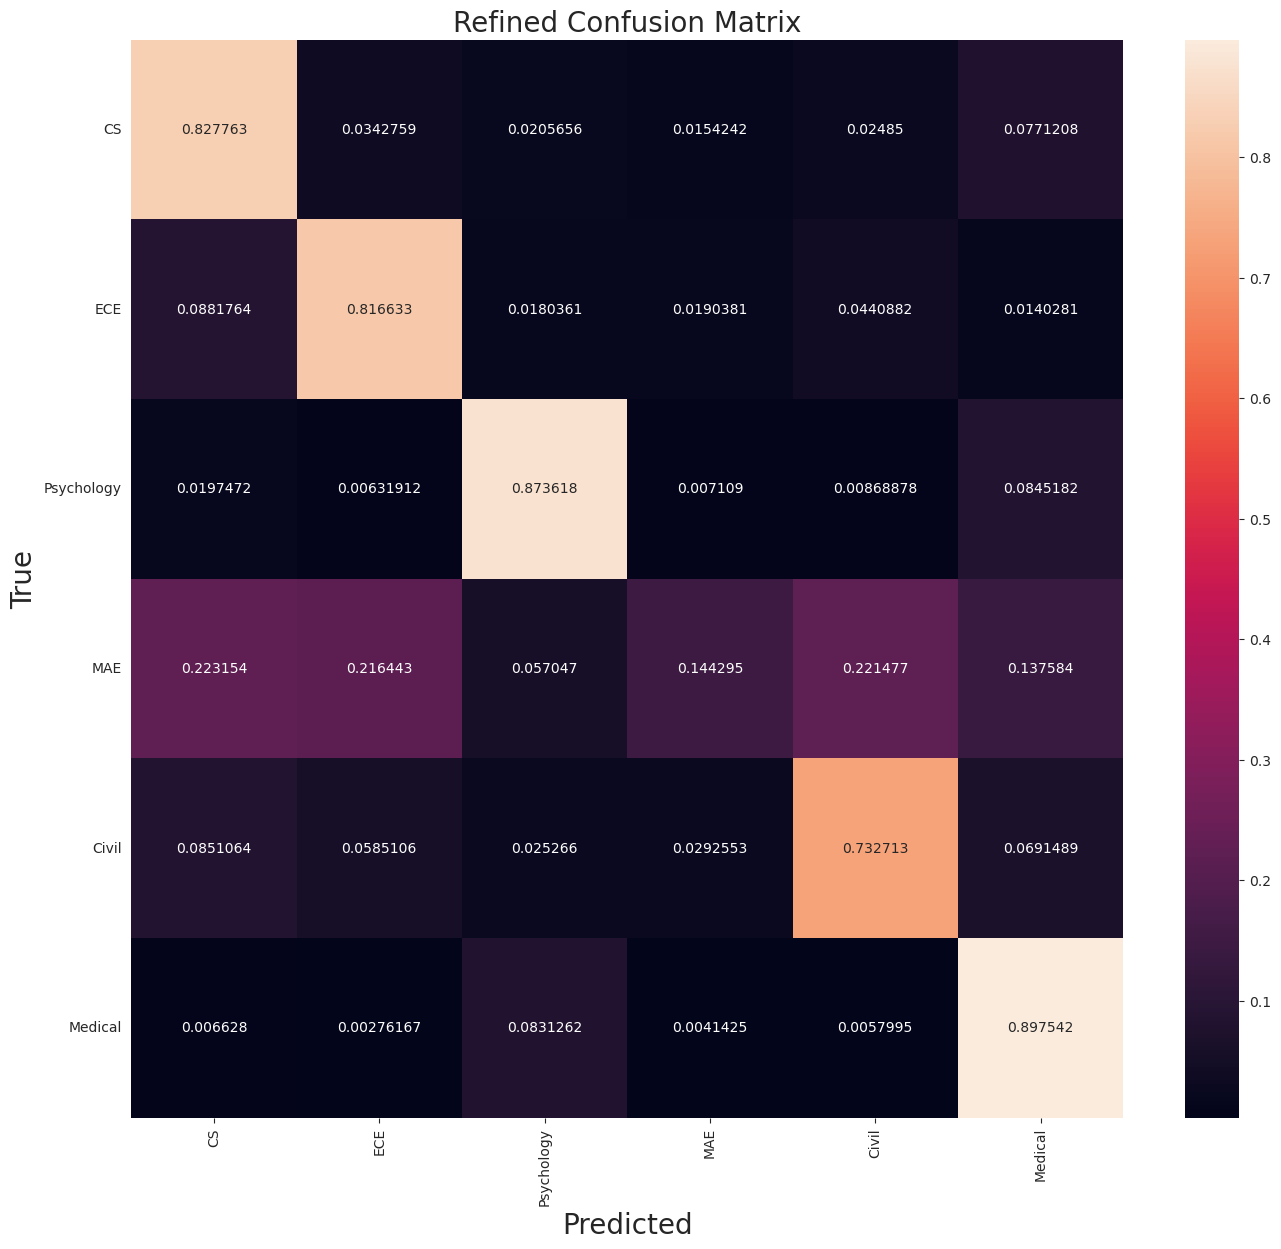

f1_score: 0.7034872334392329
Recall: Criteria for winning submissions is determined by the F1 score above!


In [36]:
labels = ['CS', 'ECE', 'Psychology', 'MAE', 'Civil', 'Medical']
cm = confusion_matrix(actual_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax, fmt="g", xticklabels=labels, yticklabels=labels)
ax.set_xlabel("Predicted", fontsize=20)
ax.xaxis.set_label_position("bottom")
plt.xticks(rotation=90)
ax.xaxis.tick_bottom()
ax.set_ylabel("True", fontsize=20)
plt.yticks(rotation=0)

plt.title("Refined Confusion Matrix", fontsize=20)

plt.show()

F1_score = f1_score(actual_labels, predicted_labels, average='macro')

print(f'f1_score: {F1_score}')
print(f"{bcolors.FAIL}{bcolors.BOLD}{bcolors.UNDERLINE}Recall: Criteria for winning submissions is determined by the F1 score above!")

# Where is the Model Underperforming?

In [37]:
# Initialize an empty DataFrame to store incorrect predictions
incorrect_pred_df = pd.DataFrame()

# Initialize a variable for the DataFrame index
df_index = 0

# Iterate through each batch of incorrect predictions
for batch in incorrect_predictions:
    # Get the length of the batch
    length = len(batch[0])
    
    # Iterate through the index and prediction pairs in the batch
    for idx, pred in zip(batch[0], batch[1]):
        # Add the index and prediction as new rows to incorrect_pred_df
        incorrect_pred_df.loc[df_index, 'index'] = int(idx.numpy())
        incorrect_pred_df.loc[df_index, 'pred'] = int(pred.numpy())
        df_index += 1

# Extract the relevant rows from the test_data DataFrame using the indices of incorrect predictions
idxs = incorrect_pred_df['index'].astype(int)
temp_df = test_data.loc[idxs][['Y1', 'Abstract', 'Domain', 'Abstract_preprocessed']]

# Add the predicted values as a new column to temp_df
temp_df['predicted'] = incorrect_pred_df['pred'].values.astype(int)
temp_df.head()

,Y1,Abstract,Domain,Abstract_preprocessed,predicted
6,3,Oil palm plantations have expanded around the ...,MAE,oil palm plantat expand around world increas c...,4
10,1,The well-known variable step-size least-mean-s...,ECE,wellknown variabl stepsiz leastmeansquar vsslm...,0
22,3,"Latterly, many problems arising in different f...",MAE,latterli mani problem aris differ field scienc...,0
24,3,Finding leakage in valves is important to trou...,MAE,find leakag valv import troubleshoot perform i...,1
25,5,"Charge variants, namely acidic and basic varia...",Medical,charg variant name acid basic variant typic fo...,2


#### The dataframe above shows where the inputs that the model is predicting incorrectly. 

The best way to take advantage of this is to figure out the most common words in each Domain and check if certain domains have alot of overlap. For example, based on the confusion matrix we can observe that Medical and Psychology seem to be mixed up by the model. Why is that? What words in the abstract overlap between the two fields that the model is unable to distinguish? 

#### **Hint: Use the collections.Counter package to determine the most commons words in each Domain.**


<!-- New line here... -->

### REMARK:  Confusion Matrix provided below is a great way to gauge where the model is underperforming. 
>  A confusion matrix is a great way to graphically visualize True Positives, False Positives, True Negatives, and False Negatives. For Example, the confusion matrix can demonstrate to you that your model is adept at distinguishing between Medical and ECE domains, but inept when it comes to distinguishing between ECE and Civil. 
> Several strategies you can consider based on feedback received from confusion matrix: 
 >> 1. Modify Model architecture? 
 >> 2. Focus on Hyperparameter tuning? 
 >> 3. Preprocessing steps?
 
 Above are a few suggestions for how you can tackle such a problem. Please feel free to research and experiment on your own!

## Grading/Submission Guidelines

## Submissions
Please email your submissions to hamzah.abdulrazzaq@lmco.com and stephen.palmier@lmco.com. All these items must be complete in order for your submission to be considered for evaluation. 
> 1. Email title set to *yourteamname_submission* 
> 2. The python notebook with all your code (.ipynb) 
> 3. F1 Score copied in with all the digits

Feel free to check out these resources to learn more about evaluation metrics used in Data Science: 
> - https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e 
> - F1 Score: https://towardsdatascience.com/how-to-evaluate-machine-learning-model-performance-in-python-135b4ae27f7e

## Evaluation Process
> - The submission deadline is on Sunday (9/8) 12PM
> - Participants are encouraged to submit as much as they can, and we will select the one with the highest F1 score too add to the leaderboard. 
> - Winners will be announced on Sunday (9/8) 2PM. We'll have a session for winning team to provide a walkthrough of their code, their strategies on how they approached the problem and engage in a discussion.  